In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


After running the cell above, you will be prompted to authorize Google Drive access. Follow the instructions to mount your drive. Once mounted, your Drive files will be accessible under `/content/drive/MyDrive/`.

In [37]:
import zipfile
import os

zip_path_part1 = '/content/drive/My Drive/Colab Notebooks/kaggle/HAM10000_images_part_1.zip'
zip_path_part2 = '/content/drive/My Drive/Colab Notebooks/kaggle/HAM10000_images_part_2.zip'

extract_path = '/content/drive/My Drive/Colab Notebooks/kaggle'
# -------------------------------------------------
# uncomment if dataset not unzipped yet

# os.makedirs(extract_path, exist_ok=True)

# def unzip_file(zip_filepath, dest_dir):
#     if os.path.exists(zip_filepath):
#         print(f"Unzipping {zip_filepath} to {dest_dir}...")
#         with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
#             zip_ref.extractall(dest_dir)
#         print(f"Done unzipping {zip_filepath}.")
#     else:
#         print(f"WARNING: File not found: {zip_filepath}")

# unzip_file(zip_path_part1, extract_path)
# unzip_file(zip_path_part2, extract_path)

# print(f"All images extracted to: {extract_path}")

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


DATA_DIR = '/content/drive/My Drive/Colab Notebooks/kaggle'
METADATA_PATH = '/content/drive/My Drive/Colab Notebooks/kaggle/HAM10000_metadata.csv'

# dirs is different from main if it doesnt work just change it back
IMG_DIRS = [os.path.join(DATA_DIR, 'HAM10000_images_part_1'), os.path.join(DATA_DIR, 'HAM10000_images_part_2')]

# matching paper
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 5 #SET TO 100 FOR ACTUAL RUN, IT WILL TAKE A LONG TIME (FIRST EPOCH TAKES LONGEST)
#this is just reporting every 10 epochs we are running on 100
#runtime set to gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [45]:
df = pd.read_csv(METADATA_PATH)

image_path_dict = {}
for img_dir in IMG_DIRS:
    if os.path.exists(img_dir):
        for img_name in os.listdir(img_dir):
            img_id = os.path.splitext(img_name)[0]
            image_path_dict[img_id] = os.path.join(img_dir, img_name)

df['path'] = df['image_id'].map(image_path_dict)

df = df.dropna(subset=['path'])

label_mapping = {
    'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6
}
df['label'] = df['dx'].map(label_mapping)

idx_to_label = {v: k for k, v in label_mapping.items()}

print(f"Total images found: {len(df)}")
df.head()

Total images found: 9786


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/kaggle...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/kaggle...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/kaggle...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/kaggle...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/Colab Notebooks/kaggle...,2


Class Weights: [ 0.21323978  1.27438469  1.30532213  2.81854839  4.41009464 10.13043478
 12.59459459]


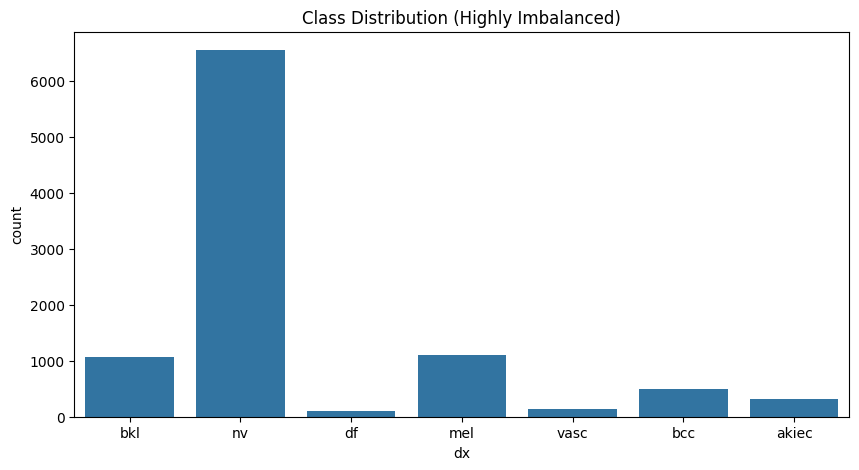

In [46]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)
plt.figure(figsize=(10, 5))
sns.countplot(x='dx', data=df)
plt.title('Class Distribution (Highly Imbalanced)')
plt.show()

In [47]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# efficientnet native size is 224x224
# copy the paper resize to 460
# paper never specifies which random compositions it does so im j running with random rotation and color jitter
# you can add affine or grayscale if u want
train_transforms = transforms.Compose([
    transforms.Resize((460, 460)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# paper doesnt use test set, never mentions which set is tested on
# im just assuming it tests on the validation set
train_dataset = SkinCancerDataset(train_df, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

EfficientNet-B0 Parameters: 	4,016,515
DenseNet121 Parameters: 		6,961,031
ResNet50 Parameters:      	23,522,375
VGG16 Parameters: 			138,533,167
Reduction in Size:        	82.92%
--------------------------------------------------
Using EfficientNet-B0 for training...


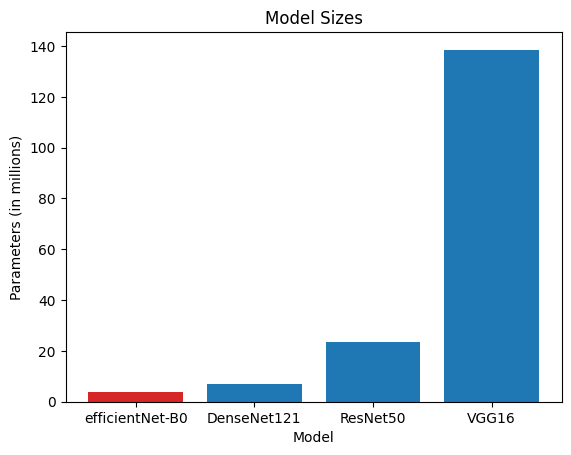

In [48]:
import matplotlib.ticker as ticker

def get_model(model_name='efficientnet'):
    if model_name == 'efficientnet':
        # Load Pretrained EfficientNet B0
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        # Modify the Classifier Head (Input features for B0 is 1280)
        model.classifier[1] = nn.Linear(in_features=1280, out_features=7)
    elif model_name == 'resnet':
        # Load ResNet50 for comparison
        model = models.resnet50(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(in_features=2048, out_features=7)
    elif model_name == 'vgg':
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(in_features=25088, out_features=7)
    elif model_name == 'densenet':
        model = models.densenet121(weights='IMAGENET1K_V1')
        model.classifier = nn.Linear(in_features=1024, out_features=7)
    return model

# ---------------- PROOF OF EFFICIENCY ----------------
eff_net = get_model('efficientnet')
res_net = get_model('resnet')
vgg_net = get_model('vgg')
den_net = get_model('densenet')

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

eff_params = count_params(eff_net)
res_params = count_params(res_net)
vgg_params = count_params(vgg_net)
den_params = count_params(den_net)

print(f"EfficientNet-B0 Parameters: \t{eff_params:,}")
print(f"DenseNet121 Parameters: \t\t{den_params:,}")
print(f"ResNet50 Parameters:      \t{res_params:,}")
print(f"VGG16 Parameters: \t\t\t{vgg_params:,}")
print(f"Reduction in Size:        \t{100 - (eff_params/res_params)*100:.2f}%")
print("-" * 50)
print("Using EfficientNet-B0 for training...")

fig, ax = plt.subplots()
bar_colors = ['tab:red', 'tab:blue', 'tab:blue', 'tab:blue']

ax.bar(['efficientNet-B0', 'DenseNet121', 'ResNet50', 'VGG16'],
        [eff_params, den_params, res_params, vgg_params],
       color=bar_colors)

def millions_formatter(x, pos):
    """The two args are the value and tick position."""
    return '%1.f' % (x * 1e-6)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.title('Model Sizes')
plt.xlabel('Model')
plt.ylabel('Parameters (in millions)')
plt.show()

model = eff_net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# this is basically useless colab cuts us off before the model finishes running
# use it for the final thing if u are running locally i guess
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []

best_val_acc = 0.0

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_epoch_loss = val_loss / len(val_loader)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)
    train_loss_hist.append(epoch_loss)
    val_loss_hist.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnet_skin_cancer.pth')

    # im just putting testing phase into here eveyr 10 epochs
    if epoch % 10 == 9:
        # Load Best Model
        model.load_state_dict(torch.load('best_efficientnet_skin_cancer.pth'))
        model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


        print("Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))


        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(label_mapping.keys()),
                    yticklabels=list(label_mapping.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix - EfficientNet B0')
        plt.show()


Starting Training...
Epoch [1/5] Train Loss: 1.5041 | Train Acc: 47.99% | Val Loss: 1.0352 | Val Acc: 59.91%
Epoch [2/5] Train Loss: 0.8437 | Train Acc: 66.65% | Val Loss: 0.7910 | Val Acc: 66.75%
Epoch [3/5] Train Loss: 0.6389 | Train Acc: 72.59% | Val Loss: 0.6824 | Val Acc: 66.85%
Epoch [4/5] Train Loss: 0.5341 | Train Acc: 76.29% | Val Loss: 0.6173 | Val Acc: 69.97%
Epoch [5/5] Train Loss: 0.4401 | Train Acc: 77.55% | Val Loss: 0.6047 | Val Acc: 73.75%


Classification Report:
              precision    recall  f1-score   support

          nv       0.98      0.73      0.84      1312
         mel       0.37      0.80      0.50       220
         bkl       0.57      0.67      0.62       214
         bcc       0.69      0.85      0.76        99
       akiec       0.56      0.59      0.57        63
        vasc       0.87      0.93      0.90        28
          df       0.72      0.82      0.77        22

    accuracy                           0.74      1958
   macro avg       0.68      0.77      0.71      1958
weighted avg       0.83      0.74      0.76      1958



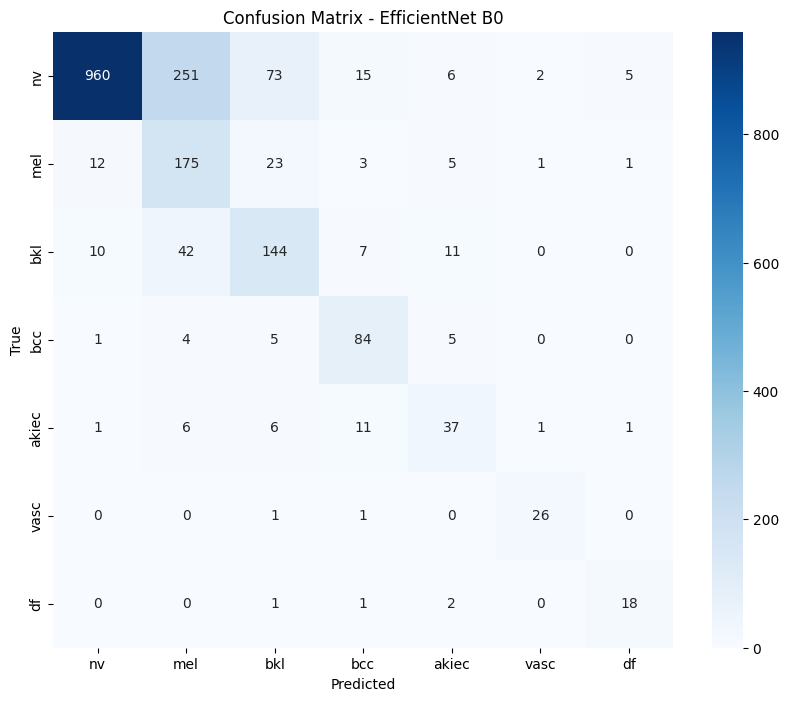

In [19]:
# i copied this part to the training loop
# uncomment it out if u need to calc stuff after training loop is done


# # Load Best Model
model.load_state_dict(torch.load('best_efficientnet_skin_cancer.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))

# Confusion Matrix Visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNet B0')
plt.show()

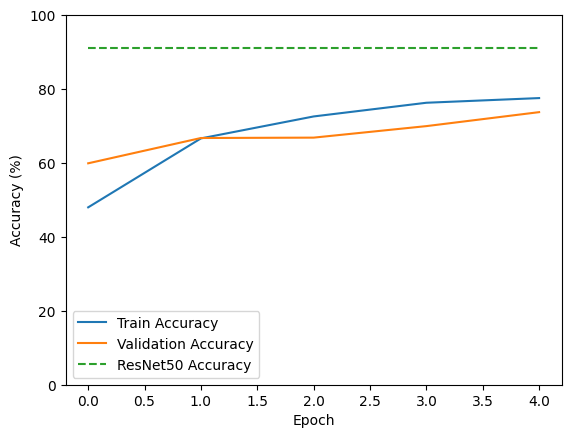

In [ ]:
#!! I manually got outs.csv from the print statements in the training block !!
# i had to do this bc my account ran out of colab gpu credits.
# if you finished training just comment out the df pd.read_csv and
# replace each df['train_acc'] with train_acc_hist etc. defined in the training block

# doing this stuff manually bc if the training block times out then train and val hist are lost
# and the training block usually times out since colab only allows a certain time limit

# df = pd.read_csv('outs.csv')

plt.ylim(0,100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.plot([91 for i in range(EPOCHS)], label='ResNet50 Accuracy', ls='--')
plt.legend()
plt.show()

# UNCOMMENT THIS TO GET LOSS GRAPH

# plt.ylim(0,1)
# plt.xlabel('Epoch')
# plt.ylabel('Loss (%)')
# plt.plot(train_loss_hist, label='Train Loss')
# plt.plot(val_loss_hist, label='Validation Loss')
# plt.legend()
# plt.show()